# Model 040 BasicCh: Coupled Steady-State Solution

This model shows example usage of the Basic model from the TerrainBento package.

Instead of the linear flux law for hillslope erosion and transport, BasicCh uses a nonlinear (cubic) law:

$\frac{\partial \eta}{\partial t} = - KA^{1/2}S - \nabla q_h$ 

$q_h = -D \left( \nabla \eta + \frac{1}{S_c^2} \left[ \nabla \eta \right]^3 \right)$

where $S_c$ is a critical slope gradient. 

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import BasicCh

In [2]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block

params = {'number_of_node_rows' : 100,
         'number_of_node_columns' : 160,
         'node_spacing' : 10.0,
         'east_boundary_closed' : False,
         'north_boundary_closed' : False,
         'west_boundary_closed' : False,
         'south_boundary_closed' :False,
         'dt' : 10,
         'K_sp' : 0.001,
         'm_sp' : 0.5,
         'n_sp' : 1.0,
         'linear_diffusivity' : 0.1,
         'slope_crit' : 0.3,
         'outlet_lowering_rate' : 0.0005,
         'output_filename': 'model_040_output'
         }

In [3]:
# initialize the model by passing the parameter dictionary
model = BasicCh(params=params)

# set a tolerance for determining steady state
tolerance = 0.0001

In [4]:
# run the model, it will take 190,000 years

# set dt and initialize the elapsed_time variable
dt = params['dt']
elapsed_time = 0 

# initialize a variable to identify if steady state has been reached
keep_running = True

# run the model until stead state has been reached. 
while keep_running == True:
    
    # save the pre-model-step topography of the core nodes to assess steady state. 
    pre_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # run the model one step
    model.run_one_step(dt)
    
    # save the post-model step topography of the core nodes to assess steady state. 
    post_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # increment elapsed time
    elapsed_time += dt
    
    # assess if steady state has been reached. 
    if max(abs(pre_topo - post_topo)) <= tolerance: # 1 mm
        keep_running = False
    
    # if time rounds to 10,000 years, print out a log message. 
    if elapsed_time % 10000 == 0:
        print('Elapsed time: ', elapsed_time)
        print('Maximum Topographic Change/Tolerance: ', np.round(max(abs(pre_topo - post_topo))/tolerance, decimals=2))       

Elapsed time:  10000
Maximum Topographic Change/Tolerance:  53.31
Elapsed time:  20000
Maximum Topographic Change/Tolerance:  126.96
Elapsed time:  30000
Maximum Topographic Change/Tolerance:  42.69
Elapsed time:  40000
Maximum Topographic Change/Tolerance:  33.28
Elapsed time:  50000
Maximum Topographic Change/Tolerance:  150.73
Elapsed time:  60000
Maximum Topographic Change/Tolerance:  25.92
Elapsed time:  70000
Maximum Topographic Change/Tolerance:  16.84
Elapsed time:  80000
Maximum Topographic Change/Tolerance:  29.8
Elapsed time:  90000
Maximum Topographic Change/Tolerance:  18.92
Elapsed time:  100000
Maximum Topographic Change/Tolerance:  11.57
Elapsed time:  110000
Maximum Topographic Change/Tolerance:  29.22
Elapsed time:  120000
Maximum Topographic Change/Tolerance:  15.21
Elapsed time:  130000
Maximum Topographic Change/Tolerance:  15.82
Elapsed time:  140000
Maximum Topographic Change/Tolerance:  17.54
Elapsed time:  150000
Maximum Topographic Change/Tolerance:  15.15
Ela

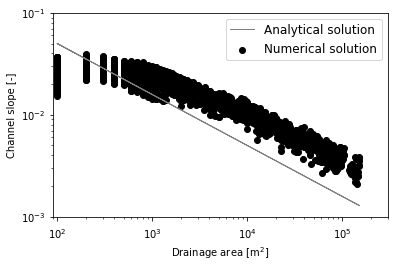

In [7]:
# MAKE SLOPE-AREA PLOT

# assign area_array and slope_array
area_array = model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]
slope_array = model.grid.at_node['topographic__steepest_slope'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# create an array for the detachment-limited analytical solution
u = params['outlet_lowering_rate']# m/yr, uplift or baselevel lowering rate
k = params['K_sp'] # fluvial erodibility
m = params['m_sp'] # discharge exponent
n = params['n_sp'] # slope exponent

# calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

# plot the analytical solution
slope_area.plot(area_array, analytical_slope_array, linestyle='-',
                color='grey', linewidth = 1, label = 'Analytical solution')

# plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Numerical solution') #plot HA data
                   
# make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-3, 1e-1)

# set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

# save out an output figure
output_figure = os.path.join('output_figures/maintext_taylor_hillslopes_slope_area.eps')
fig.savefig(output_figure, bbox_inches='tight', dpi=1000) # save figure

In [8]:
#export NetCDF for Paraview image of topography
output_file = os.path.join('output_netcdfs/maintext_taylor_hillslopes.nc')
write_netcdf(output_file, model.grid, format='NETCDF3_64BIT', names='topographic__elevation')

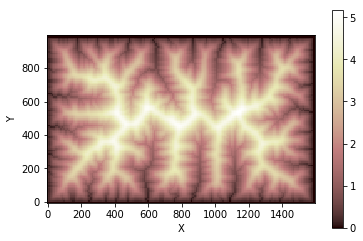

In [9]:
# make a plot of the final steady state topography
imshow_grid(model.grid, 'topographic__elevation')